In [26]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pour divisez les donnees en sous-ensembles d'entraînement et de test aléatoires.
from sklearn.model_selection import train_test_split

# pour calculer la matrice de confusion
from sklearn.metrics import confusion_matrix

# pour réduisez le taux d'apprentissage lorsqu'une métrique a cessé de s'améliorer.
from keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

# pour pouvoir importer utiliser le modèle pré-entraîner VGG19
from tensorflow.keras.applications import VGG19

# pour convertit le vecteur (y) de classe (entiers) en matrice de classe binaire.
from tensorflow.keras.utils import to_categorical

# pour générer des images altere
from keras.preprocessing.image import ImageDataGenerator

# pour initialise le methode de le desente gradien
from tensorflow.keras.optimizers import SGD, Adam

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [2]:
dataset_dir = "./kvasir-dataset"

In [3]:
def get_dataCategories(dataset_dir):
    """
        optenire les categories (classe) du dataset a partire du chemin du dataset 
        en question.

    Args:
        dataset_dir (str): chemin du dataset

    Returns:
        list: liste des categories
        list: liste des nombre de fichier par categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])




categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df.head()

number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500


In [4]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        lit les images du dataset et les redimensionner en utilisent les dimensions
        (img_wid x img_high ) pour cree l'ensmble des features X ainsi que les labels y

    Args:
        datadir (str): chemin du dataset
        categories (str): les different classes du dataset
        img_wid (int): custom width
        img_high (int): custom height

    Returns:
        X(numpy): l'ensmble des features (i.e: comporte toute les images lu) 
        y(numpy): l'ensmble des labels (i.e: comporte les categorie de chaque image de X)
    """    
    
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y




img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (4000, 100, 100, 3)
y: (4000,)


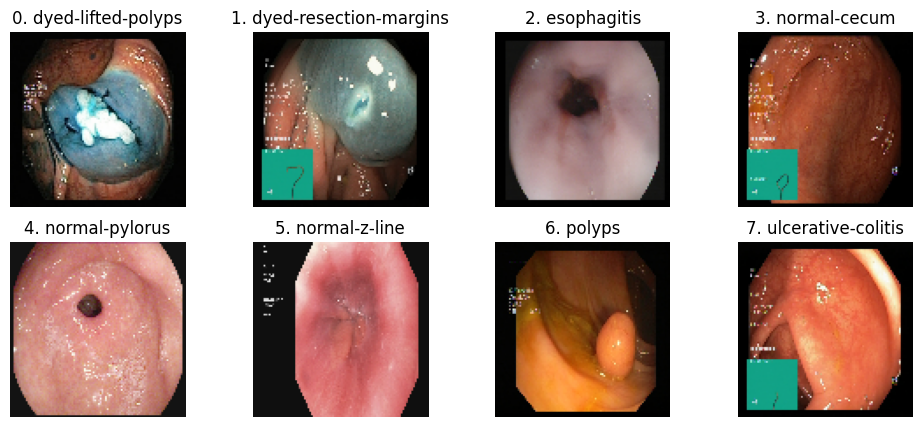

In [5]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

In [6]:
# en convertie y en format scaler
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


In [7]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


In [8]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


In [9]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
train_ds = train_generator.flow(x_train, y_train, batch_size= batch_size)
val_ds = val_generator.flow(x_val, y_val, batch_size=batch_size)

In [78]:
# si il a deja ete cree et sauvgarde --> lire le model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    # load model
    base_model = load_model("./saved_model/vgg19_model.h5")
    
# si il n'a pas deja ete cree --> cree le model er le saugrade 
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

In [79]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

In [80]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

In [81]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              4719616   
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)              

In [82]:
""" Initializing the hyperparameters """

# initialise le nombre d'échantillons d'apprentisage
batch_size = 100

# initialise le nombre d'iteration
epochs = 50

# taux d'apprentisage
learn_rate = 0.001

# initilisation de la descente du gradient
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# initilisation de la descente du gradient Adam
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# compiler le model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall", "AUC"])


In [83]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.01, patience=3, min_lr=1e-5)

In [35]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'endoscopy_v1_{epoch:02d}_{accuracy:.3f}.h5',
    save_best_only=True,
    monitor='accuracy',
    mode='max'
)

In [84]:
# si model a ete deja entrainer et sauvgarde ---> lire le model
if os.path.isfile("./saved_model/model.h5"):

    # lire le model
    model = load_model("./saved_model/model.h5")

    # si l'historique du model a ete sauvgarde --> lire l'historique
    if os.path.isfile("./saved_model/model_history.npy"):

        # lire l'historique
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# si le model n'a pas ete deja entrainer --> entrainer le model
else:
    history = model.fit(
        train_ds,
        # x_train,
        # y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data= val_ds,
        validation_steps=10,
        callbacks=[lrr],
        verbose=1,
    )
    history = history.history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")


Epoch 1/50
22/22 [==============================] - 40s 2s/step - loss: 2.4667 - accuracy: 0.1678 - precision: 0.1418 - recall: 0.0089 - auc: 0.5700 - val_loss: 1.8593 - val_accuracy: 0.2865 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7818 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 36s 2s/step - loss: 2.0002 - accuracy: 0.2201 - precision: 0.3077 - recall: 0.0019 - auc: 0.6333 - val_loss: 1.7979 - val_accuracy: 0.2938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8106 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 37s 2s/step - loss: 1.5485 - accuracy: 0.3514 - precision: 0.5162 - recall: 0.0941 - auc: 0.8239 - val_loss: 1.2065 - val_accuracy: 0.3917 - val_precision: 0.4457 - val_recall: 0.2479 - val_auc: 0.8856 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 36s 2s/step - loss: 1.3115 - accuracy: 0.4313 - precision: 0.4908 - recall: 0.2126 - auc: 0.8746 - val_loss: 1.1235 - val_accuracy:

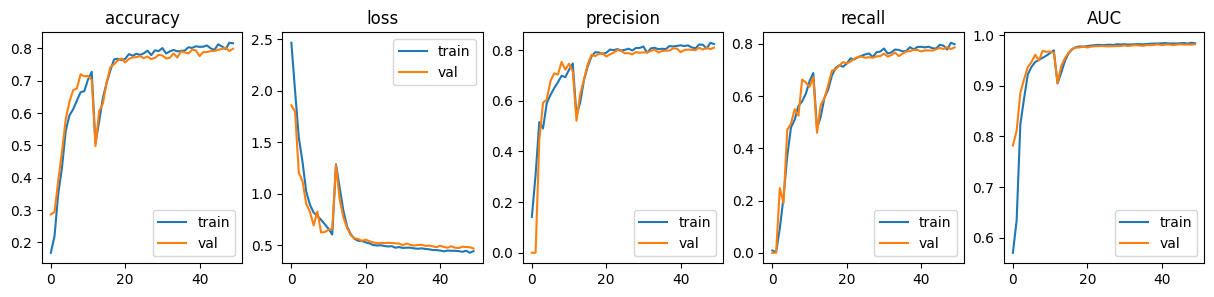

In [85]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].plot(history['accuracy'], label='train')
ax[0].plot(history['val_accuracy'], label='val')
ax[0].set_title('accuracy')
ax[0].legend()

ax[1].plot(history['loss'], label='train')
ax[1].plot(history['val_loss'], label='val')
ax[1].set_title('loss')
ax[1].legend()

ax[2].plot(history['precision'], label='train')
ax[2].plot(history['val_precision'], label='val')
ax[2].set_title('precision')
ax[2].legend()

ax[3].plot(history['recall'], label='train')
ax[3].plot(history['val_recall'], label='val')
ax[3].set_title('recall')
ax[3].legend()

ax[4].plot(history['auc'], label='train')
ax[4].plot(history['val_auc'], label='val')
ax[4].set_title('AUC')
ax[4].legend()

plt.show()

In [86]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))

Test loss: 0.482
Test accuracy: 0.79


In [87]:
"""
    Les fonctions utilise affiche la matrice de confusion
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       affiche la matrice de confusion appartire de l'ax entre

    Args:
        ax (plt): ax qui sert a affiche la matrice
        cm (numpy): matrice de confusion
        classes (list): liste des classes
        cmap (plt): couluer de la matrice
        title (str): titre de la matrice
        normalize (booleen): vrai affichre cm normalisee

    Returns:
        plt: l'ax qui sera affiche
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
        afficher la cm normalisee et non normalisee

    Args:
        cm (numpy): matrice de confusion
        classes (list): liste des classes
        fig_size (_type_): _description_
        cmap (plt, optional): couluer de la matrice. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

In [88]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 4s 130ms/step


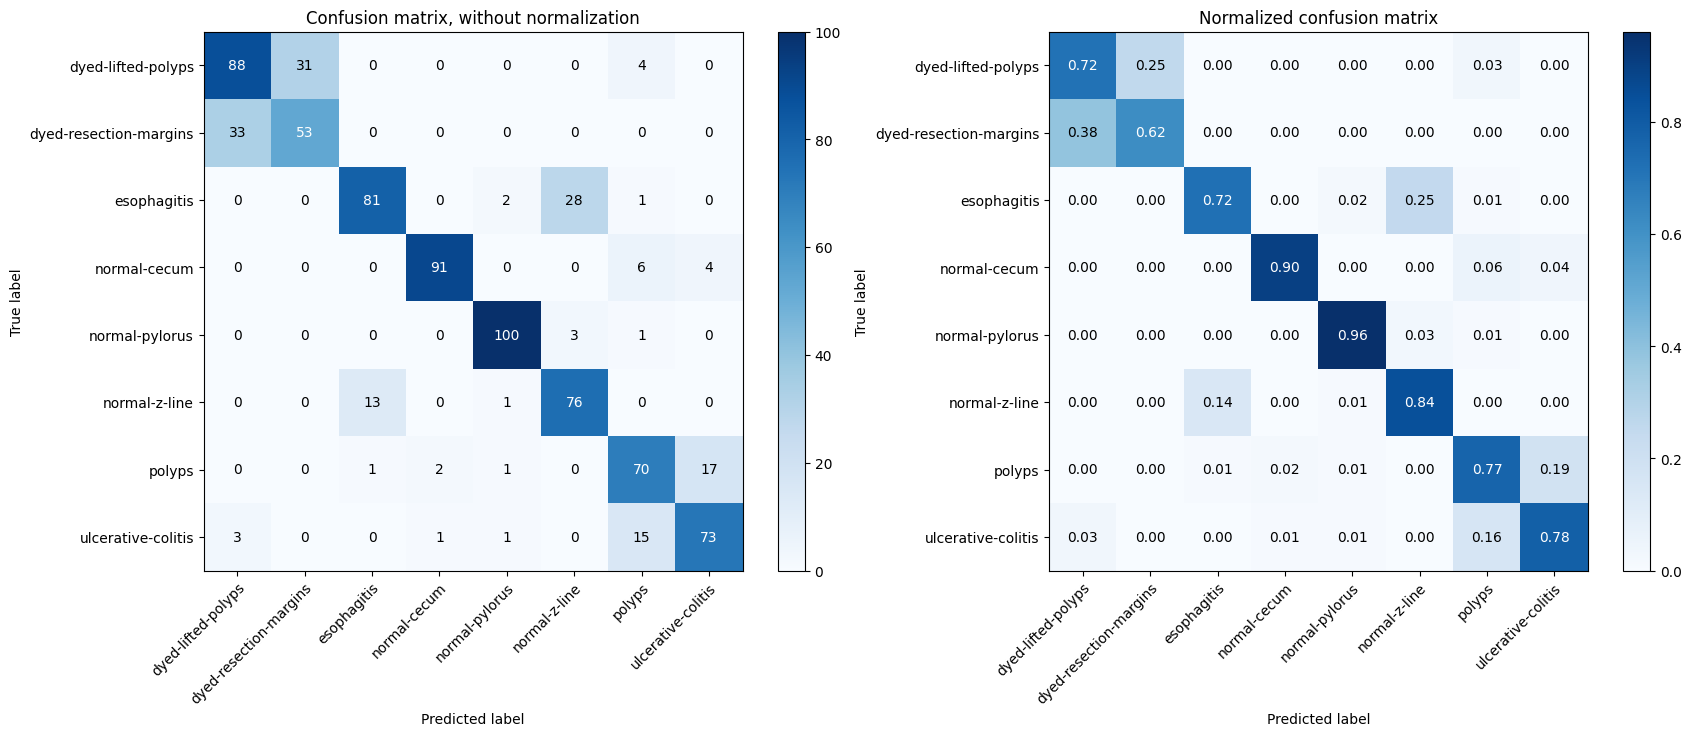

In [89]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

1/1 [==============================] - 0s 12ms/step


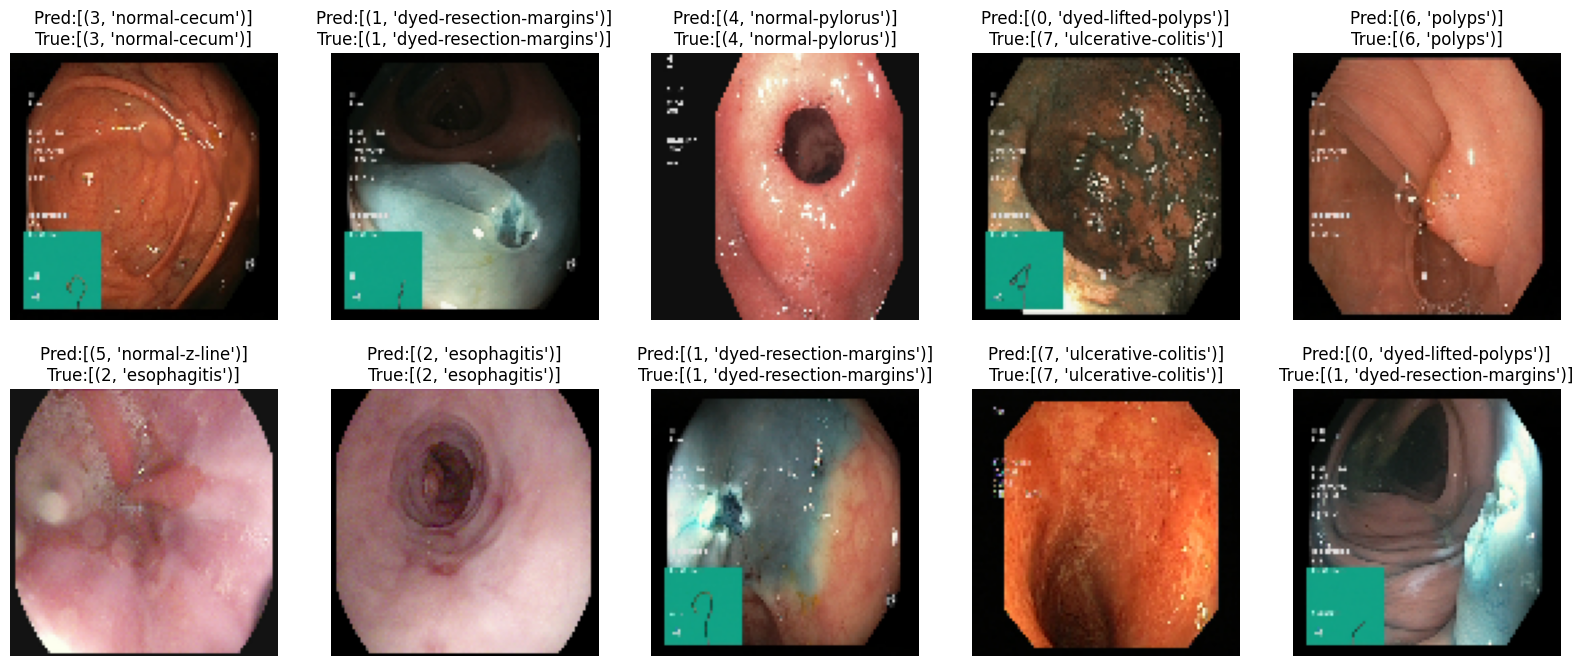

In [90]:
def predict_categorie_img(img, model, categories):
    """
        predire la classe d'une image donnee

    Args:
        img (numpay): l'image donnee
        model (_type_): le model utilise pour la prediction
        categories (list): liste des classes

    Raises:
        TypeError: erreur si l'image n'est pas en RGB (image_dim < 3)

    Returns:
        int: l'index de la classes predie
        str: la classe predie
    """    
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]





plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()